For the first part of predicting ICU LOS, we will be loading in the datasets that we will be using, namely: 
- ICU Stays
- Admissions data
- Patients data (i.e., demographics)
- Diagnosis 
- Lab events

As part of the data cleaning, we will do the following:
- verify LOS is correct (difference between ICU discharge and admit times)
- calculate which admission # and ICU stay # each stay was
- calculate age at admission, removing patients who are under 18 and over 80
- remove ICU stays if a patient died during that stay (but keeping patients who died after the date of the ICU stay)
- bi

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.testing

## 1. Read in and view data

In [533]:
df_icu = pd.read_csv('data/Part1/ICUSTAYS.csv')
len(df_icu)

61532

the main useful columns in the ICUSTAYS table to us are: SUBJECT_ID, HADM_ID, (possibly) ICUSTAY_ID, and LOS.

I will also use INTIME and OUTTIME to make sure that the LOS is correct, especially since the database sources can be different

In [534]:
# convert date time format
df_icu.OUTTIME = pd.to_datetime(df_icu.OUTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_icu.INTIME = pd.to_datetime(df_icu.INTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# recalculate LOS using difference between INTIME and OUTTIME to check the LOS column is correct
los_check = (df_icu.OUTTIME - df_icu.INTIME).apply(lambda x: (x.total_seconds()/86400))

# round both so they would match
df_icu['los_check'] = los_check.round(4)
df_icu['LOS_rounded'] = df_icu.LOS.round(4)


In [535]:
# check that my calculation of ICU LOS and the one given match:

#pandas.testing.assert_series_equal(df_icu.los_check, df_icu.LOS_rounded)

so the LOS that is given is not always equal to the difference between outtime and intime - I will investigate this a bit further.

In [536]:
# check what the difference between these are
df_icu['LOS_diff'] = abs(df_icu.LOS_rounded - df_icu.los_check)

df_icu['LOS_equals'] = np.where(abs(df_icu.los_check-df_icu.LOS_rounded)==0, 1, 0)

df_icu.loc[df_icu['LOS_equals']==0][['LOS_diff']]

,LOS_diff
61,0.0001
869,0.0001
963,0.0001
1033,NaN
1067,0.0001
...,...
59055,0.0001
59705,0.0001
60576,0.0001
61122,0.0001


it turns out most of the differences was due to rounding differences so I will look for places where differences are greater than 0.0002 (for some reason, differences = to 0.0001 get flagged even with <=)

In [537]:
df_icu['LOS_equals'] = np.where(abs(df_icu.los_check-df_icu.LOS_rounded)<=0.0002, 1, 0)

df_icu.loc[df_icu['LOS_equals'] == 0][['LOS_diff','OUTTIME']]

,LOS_diff,OUTTIME
1033,NaN,NaT
6451,NaN,NaT
10165,NaN,NaT
10507,NaN,NaT
13080,NaN,NaT
15156,NaN,NaT
17759,NaN,NaT
18442,NaN,NaT
27840,NaN,NaT
29117,NaN,NaT


so it turns out the only rows that are causing this is due to NaT in the OUTTIME and having a NaN in the LOS. Good, because we want to remove these anyway! Let's go ahead and remove any rows that have NaT for INTIME, OUTTIME, and LOS.

In [538]:
df_icu.dropna(subset = ["LOS"], inplace=True)
df_icu.dropna(subset = ["INTIME"], inplace=True)
df_icu.dropna(subset = ["OUTTIME"], inplace=True)

In [539]:
len(df_icu)

61522

looks like 10 cases had LOS=NaN (there weren't any more that had INTIME = NaT or OUTTIME = NaT)

In [540]:
# take out the columns I want to keep
df_icu = df_icu[["SUBJECT_ID", "HADM_ID","ICUSTAY_ID","LOS", "OUTTIME"]]

In [541]:
print('max ICU stay: %f' % max(df_icu.LOS))
print('min ICU stay: %f' % min(df_icu.LOS))

max ICU stay: 173.072500
min ICU stay: 0.000100


### ADMISSIONS DATA

Use this for multiple admits - # of admissions can be used as a predictor

I am avoiding using discharge location (for example, home) because that is something that would not be known for future patients until they are about to be discharged

In [542]:
df_adm = pd.read_csv('data/Part1/ADMISSIONS.csv')

In [543]:
len(df_adm)

58976

In [544]:
# convert format
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [545]:
# subset the columns I want to use
df_adm = df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DEATHTIME','ADMISSION_TYPE','ADMISSION_LOCATION','ETHNICITY','INSURANCE']]

In [546]:
df_adm['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [547]:
# convert ethnicity to fewer categories
df_adm['ETHNICITY_WHITE'] = df_adm['ETHNICITY'].str.contains('WHITE', case=True, regex=False).astype(int)
df_adm['ETHNICITY_BLACK'] = df_adm['ETHNICITY'].str.contains('BLACK', case=True, regex=False).astype(int)
df_adm['ETHNICITY_HISPANIC/LATINO'] = df_adm['ETHNICITY'].str.contains('HISPANIC', case=True, regex=False).astype(int)
df_adm['ETHNICITY_ASIAN'] = df_adm['ETHNICITY'].str.contains('ASIAN', case=True, regex=False).astype(int)
df_adm['ETHNICITY_NATIVE'] = df_adm['ETHNICITY'].str.contains('NATIVE', case=True, regex=False).astype(int)

In [548]:
df_adm = df_adm.drop(columns=['ETHNICITY'])

Count the admission number for each partient

In [549]:
df_adm['ADMISSION_NUM'] = df_adm.groupby(['SUBJECT_ID']).cumcount()+1

The admissions dataset is substantially smaller than the ICU Stays data... this could be due to multiple ICU stays in a single admission. 
Let's go ahead and merge on hospital admission ID

In [550]:
df_joined = df_icu.merge(df_adm,  how = 'inner', on = ['HADM_ID','SUBJECT_ID'])
len(df_joined)

61522

In [551]:
# show number of unique subjects... shows that there are some subjects in admissions that are not in df_icu
print('# of unique subjects in admissions data: %i' % df_adm['SUBJECT_ID'].nunique())
print('# of unique subjects in ICU/admissions joined data: %i '% df_joined['SUBJECT_ID'].nunique())

# count number of entries with deathtime not NaN, to be dropped later
print('# of subjects who have died: %i' % df_joined['DEATHTIME'].count())

# of unique subjects in admissions data: 46520
# of unique subjects in ICU/admissions joined data: 46467 
# of subjects who have died: 6608


### PATIENTS DATA

Get demographic variables: age, gender, death in ICU

In [552]:
df_demographics = pd.read_csv('data/Part1/PATIENTS.csv')

In [553]:
# let's go ahead and convert DOB and DOD to the same date time format as the admissions data
df_demographics.DOB = pd.to_datetime(df_demographics.DOB, format = '%Y-%m-%d %H:%M:%S', errors='coerce')
df_demographics.DOD_HOSP = pd.to_datetime(df_demographics.DOD_HOSP, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_demographics.DOD = pd.to_datetime(df_demographics.DOD, format = '%Y-%m-%d %H:%M:%S', errors='coerce')
df_demographics.DOD_SSN = pd.to_datetime(df_demographics.DOD_SSN, format = '%Y-%m-%d %H:%M:%S', errors='coerce')

print(len(df_demographics))

46520


so it looks like there are a few more patients in here than in the ICU data (46,467), but same as admissions data

__Dealing with deceased patients__

In [554]:
print(df_demographics['DOD'].count())
print(df_demographics['DOD_HOSP'].count())

15759
9974


There's a lot more patients who are recorded as dead [DOD] than those who have a DOD_HOSP entry. We will take into account DOD_HOSP because these are the deaths recorded from the hospital--we only want to omit the patients who died during their hospital stay, not all patients who have died. 

Also note, there's a lot more patients recorded as dead here than in the admissions data (6608)... 

In [555]:
# subset the columns I want to use - I'm only going to use DOD_HOSP to omit the patients who actually died during their stay at the hospital
df_demographics = df_demographics[['SUBJECT_ID','GENDER','DOB','DOD_HOSP']]

In [556]:
df_joined = df_joined.merge(df_demographics,  how = 'inner', on = ['SUBJECT_ID'])

df_joined['DOD_HOSP'].count()

16213

DOD_HOSP count is much higher in df_joined than in just df_demographics because there are repeats of the same patients! 
We only want to remove an entry if the specific ICU admission resulted in death, not if a patient evenetually died in one of their subsequent hospital visits.

We will do this by getting the last ICU stay for each admission, and of these, removing the ICU stay row where the patient has died. 

In [557]:
# Count ICU stay number for each admission (ICUSTAY_NUM) and the total number of ICU stays
df_joined['TOTAL_ICUSTAYS'] = df_joined.groupby(['SUBJECT_ID']).cumcount()+1
df_joined['ICUSTAY_NUM'] = df_joined.groupby(['SUBJECT_ID','HADM_ID']).cumcount()+1

In [558]:
# get the last ICU stay for each person by shifting and getting rows where next row is null
df_joined['NEXT_ICUSTAY'] = df_joined.groupby('SUBJECT_ID').ICUSTAY_ID.shift(-1)
df_lastStay = df_joined[df_joined['NEXT_ICUSTAY'].isnull()]

In [559]:
# seems to be a discrepancy between DOD_HOSP (date of death in hospital) and deathtime
print(df_lastStay['DEATHTIME'].count())
print(df_lastStay['DOD_HOSP'].count())

5797
9958


In [560]:
df_discrep.head(0)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,OUTTIME,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,ETHNICITY_ASIAN,ETHNICITY_NATIVE,ADMISSION_NUM,GENDER,DOB,DOD_HOSP,TOTAL_ICUSTAYS,ICUSTAY_NUM,NEXT_ICUSTAY,OUTDATE


In [561]:
df_discrep = df_lastStay[df_lastStay['DEATHTIME'].isnull() & df_lastStay['DOD_HOSP'].notnull()]

check to see if DOD_HOSP is the same as the ICU discharge date (OUTTIME) to make sure that we aren't missing any ICU stays that resulted in death. Not using dischtime since that is the discharge from the hospital stay and not discharge from ICU stay

In [562]:
df_discrep.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'OUTTIME', 'ADMITTIME',
       'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'INSURANCE', 'ETHNICITY_WHITE', 'ETHNICITY_BLACK',
       'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN', 'ETHNICITY_NATIVE',
       'ADMISSION_NUM', 'GENDER', 'DOB', 'DOD_HOSP', 'TOTAL_ICUSTAYS',
       'ICUSTAY_NUM', 'NEXT_ICUSTAY'],
      dtype='object')

In [563]:
df_discrep['OUTTIME']

6       2114-07-07 18:01:16
21      2167-06-03 17:47:16
26      2107-09-14 18:34:48
29      2118-01-20 11:12:45
36      2189-11-13 22:11:28
                ...        
61359   2142-11-14 21:04:45
61386   2114-09-15 15:44:51
61482   2133-10-22 15:47:56
61488   2176-09-06 15:18:59
61509   2134-03-12 12:14:42
Name: OUTTIME, Length: 4161, dtype: datetime64[ns]

In [564]:
# get just the date (not time) of ICU discharge time
df_discrep = df_discrep.copy()
df_discrep['OUTDATE'] =  df_discrep['OUTTIME'].dt.date
df_discrep['OUTDATE'] = pd.to_datetime(df_discrep.OUTDATE, format = '%Y-%m-%d %H:%M:%S', errors='coerce')

In [565]:
df_discrep['OUTDATE']

6       2114-07-07
21      2167-06-03
26      2107-09-14
29      2118-01-20
36      2189-11-13
           ...    
61359   2142-11-14
61386   2114-09-15
61482   2133-10-22
61488   2176-09-06
61509   2134-03-12
Name: OUTDATE, Length: 4161, dtype: datetime64[ns]

In [566]:
# for patients who died on the same day they were discharged from ICU,
# reset DEATHTIME to the ICU disch time since it was null before
df = df_discrep[df_discrep['OUTDATE'] == df_discrep['DOD_HOSP']]
df.loc[:,'DEATHTIME'] = df_discrep['OUTDATE']

In [567]:
# update 'deathtime' in df_lastStay
indices=df.index
deathtimes = pd.Series(df['DEATHTIME'], index=indices)
df_lastStay.update(deathtimes, overwrite = True)

In [568]:
# now, remove the ICU stays that ended in death from df_joined 
ICUDeaths = df_lastStay[df_lastStay['DEATHTIME'].notnull()]['ICUSTAY_ID']
df_merged = pd.merge(df_joined, ICUDeaths, how='outer', on = 'ICUSTAY_ID',indicator=True)

In [569]:
# keep only the ones that were "left only" - meaning they did not die in the ICU
df_joined = df_merged.loc[df_merged._merge == 'left_only']

In [570]:
# check that if patient died, this was not their last ICU stay
df_joined[df_joined['DEATHTIME'].notnull() & df_joined['NEXT_ICUSTAY'].isnull()]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,OUTTIME,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,ETHNICITY_ASIAN,ETHNICITY_NATIVE,ADMISSION_NUM,GENDER,DOB,DOD_HOSP,TOTAL_ICUSTAYS,ICUSTAY_NUM,NEXT_ICUSTAY,_merge


now calculate age at admission and drop those who are over 80 and under 18

In [571]:
df_joined = df_joined.copy()
df_joined['AGE'] = df_joined.ADMITTIME.dt.year - df_joined.DOB.dt.year
df_joined[df_joined['AGE']>100]
df_joined = df_joined[df_joined.AGE<300]
df_joined = df_joined[df_joined['AGE']>17]

In [572]:
# now remove columns we don't need
df_joined = df_joined.drop(['_merge', 'NEXT_ICUSTAY', 'DOD_HOSP','DOB','TOTAL_ICUSTAYS','DEATHTIME','ADMITTIME','DISCHTIME','OUTTIME',], axis=1)

Ok, by this point we have:
- removed ICU stays only if patients died during that stay (or on the day of ICU discharge)
- calculated age at admission, removing patients who are over 80 (300)
- verified LOS is correct
- calculated which admission # and ICU stay # each stay was
- cleaned through the ICUSTAYS, ADMISSIONS, PATIENTS datasets

### DIAGNOSIS

The diagnosis each person has is probably also useful information - certain diagnoses are much more complex than others. But many people will also have more than 1 single diagnosis. This could also be useful information if they have comorbidities.

In [573]:
df_diagnoses = pd.read_csv('data/Part1/DIAGNOSES_ICD.csv')

In [574]:
# check number of unique ICD9 codes
len(df_diagnoses.ICD9_CODE.unique())

6985

* ICD-9 codes can apparently be classified though, so this may be worth doing! https://en.wikipedia.org/wiki/List_of_ICD-9_codes

Take only the first 3 digits and categorize them. 

In [575]:
df_diagnoses['TRUNCATED_CODE'] = df_diagnoses['ICD9_CODE'].astype(str).str[0:3]
df_diagnoses['TRUNCATED_CODE'] = pd.to_numeric(df_diagnoses['TRUNCATED_CODE'], errors = 'coerce')

In [576]:
bins = [0,1,139,239,279,289,319,389,459,519,579,629,679,709,739,759,779,799,999]
bin_labels=["18","1", "2", "3","4","5","6","7","8","9","10","11","12","13","14","15","16","17"]

In [577]:
df_diagnoses['ICD_BINS'] = pd.cut(df_diagnoses['TRUNCATED_CODE'], bins,labels=bin_labels)
df_diagnoses.loc[(df_diagnoses.ICD9_CODE.str[0][:, None] == ['V', 'E']).any(1),'ICD_BINS'] = '18'

In [578]:
df_diagnoses.head(0)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,TRUNCATED_CODE,ICD_BINS


So at this point, each row has one ICD9_CODE and corresponding ICD_BINS number

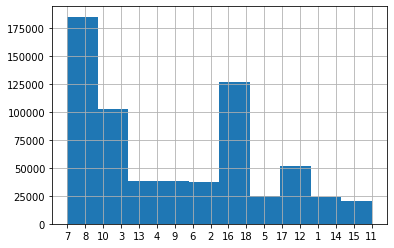

In [579]:
df_diagnoses['ICD_BINS'].hist()

In [580]:
df_diagnoses[df_diagnoses['ICD_BINS'].isnull()].count()

ROW_ID            47
SUBJECT_ID        47
HADM_ID           47
SEQ_NUM            0
ICD9_CODE          0
TRUNCATED_CODE     0
ICD_BINS           0
dtype: int64

Account for multiple diagnoses per person by converting ICD_bins into multiple dummy variables and then grouping by HADM_ID, going from long to wide format

In [581]:
df_diagnoses = pd.get_dummies(df_diagnoses, columns=['ICD_BINS'])

In [582]:
df_diagnoses.head(0)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,TRUNCATED_CODE,ICD_BINS_18,ICD_BINS_1,ICD_BINS_2,ICD_BINS_3,...,ICD_BINS_8,ICD_BINS_9,ICD_BINS_10,ICD_BINS_11,ICD_BINS_12,ICD_BINS_13,ICD_BINS_14,ICD_BINS_15,ICD_BINS_16,ICD_BINS_17


In [583]:
a=df_diagnoses.groupby("HADM_ID")

In [584]:
# group by Hospital admission ID, and for each column of ICD_bins, look for max, 
# which would be 1 if there was a diagnosis, within the grouping

def f(x):
    d = {}
    d = x.filter(regex=("ICD_BINS*")).max()
    
    return pd.Series(d)

df_diagnoses = df_diagnoses.groupby('HADM_ID').apply(f)
df_diagnoses.reset_index(inplace=True)

In [585]:
len(df_diagnoses)

58976

In [586]:
df_joined = pd.merge(df_joined, df_diagnoses, how='inner', on = 'HADM_ID',indicator = False)

In [587]:
assert len(df_joined) == df_joined['ICUSTAY_ID'].nunique()

### LAB EVENTS

There are a TON of different types of labs that can be taken, so I will go with the simpler approach here and simply use this as a binary: whether someone has at least one or more lab event labeled "Abnormal" or not for that admission

In [588]:
df_labevents = pd.read_csv('data/Part1/LABEVENTS.csv')

In [589]:
df_labevents.head(0)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG


In [590]:
# of the lab events that are not null, check what different types there are
df_labevents[df_labevents['FLAG'].notnull()]['FLAG'].unique()

array(['abnormal', 'delta'], dtype=object)

In [591]:
# for abnormal events, craete new column with binary - 1 if abnormal event, 0 if none
# then sum up the total number of abnormal events within a hospital admission
df_labevents['ABNORMAL_EVENT'] = np.where(df_labevents['FLAG']=='abnormal', 1, 0)
abnormal_events = df_labevents.groupby('HADM_ID')['ABNORMAL_EVENT'].sum()
abnormal_events = abnormal_events.rename("ABNORMAL_EVENTS_TOTAL")

In [592]:
len(abnormal_events)

58151

In [593]:
df_joined = pd.merge(df_joined, abnormal_events, how = 'inner', on='HADM_ID',indicator = False)

In [594]:
df_joined.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'ETHNICITY_WHITE', 'ETHNICITY_BLACK',
       'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN', 'ETHNICITY_NATIVE',
       'ADMISSION_NUM', 'GENDER', 'ICUSTAY_NUM', 'AGE', 'ICD_BINS_18',
       'ICD_BINS_1', 'ICD_BINS_2', 'ICD_BINS_3', 'ICD_BINS_4', 'ICD_BINS_5',
       'ICD_BINS_6', 'ICD_BINS_7', 'ICD_BINS_8', 'ICD_BINS_9', 'ICD_BINS_10',
       'ICD_BINS_11', 'ICD_BINS_12', 'ICD_BINS_13', 'ICD_BINS_14',
       'ICD_BINS_15', 'ICD_BINS_16', 'ICD_BINS_17', 'ABNORMAL_EVENTS_TOTAL'],
      dtype='object')

In [595]:
len(df_joined)

45054

### EXPORT DATAFRAME

In [596]:
df_joined.to_csv('data/ICU_combined.csv', index=False)